### Setup

In [1]:
from IPython.display import clear_output
!pip install Pillow==9.0.0
!pip install transformers
clear_output()

### Import Libraries

In [2]:
import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from transformers import pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "grey",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

### Scraping tweets by keyword

In [4]:
access_token = ""
access_token_secret = ""
consumer_key = ""
consumer_key_secret = ""

auth = tweepy.OAuthHandler(consumer_key ,consumer_key_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [9]:
user = []
text = []
likes = []
follower = []

for tweet in tweepy.Cursor(api.search, q='ahok -filter:retweets', lang="id").items(100):
    likes.append(tweet.favorite_count)
    text.append(tweet.text)
    user.append(tweet.user.screen_name)
    follower.append(tweet.user.followers_count)

In [10]:
df = pd.DataFrame({'username': user,
                   'tweets': text,
                   'likes': likes,
                   'followers': follower})

df

,username,tweets,likes,followers
0,Evan_sofian1980,"@Uki23 Emang gubernur jokowi kerjanya apa mas,...",0,11
1,Fr4nst,@Aswad4242 @d54714 @Uki23 Betul. Anies dpt war...,0,2508
2,Rick12101624,@detikcom Ini dari jaman belanda belum jadi ne...,1,27
3,DaengKayo89,@CupsCupu @Uki23 Jelas jelas itu ada datanya k...,0,569
4,democrazymedia,"Harga BBM Gak Masuk Akal, PKS Pertanyakan Kerj...",0,67979
...,...,...,...,...
95,dharmahutauruk,@marlina_idha Siapa yang jadi teladan mu? Ahok...,0,157
96,id3nesia,@JohnVirgoVj Jadi sebenarnya di Pilkada Jkt 20...,0,751
97,Mohammed_Dodi1,"Pak Heru gak salah,mas.\nPak Jokowi gak salah....",0,3383
98,Aldi38461127,@triwul82 Kelihatan banget settingannya... Cb ...,3,2


### Update Stopwords

In [11]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))
len(stop_words)

757

In [12]:
data = 'https://raw.githubusercontent.com/Braincore-id/IndoTWEEST/main/stopwords_twitter.csv'
df_stopwords = pd.read_csv(data, names=['stopword'])

In [13]:
df_stopwords = df_stopwords.sort_values(by="stopword", ascending=True)
df_stopwords.reset_index(drop=True, inplace=True)

In [14]:
df_stopwords

,stopword
0,33books
1,GA
2,TIA
3,a thread
4,aja
...,...
223,yakan
224,yg
225,ygy
226,yoi


In [15]:
new_stopwords = []

for data in df_stopwords['stopword']:
  new_stopwords.append(data)

In [16]:
stop_words.update(new_stopwords)
len(stop_words)

980

### WordCloud Visualization

In [17]:
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
pat3 = r'^RT[\s]+'
combined_pat = r'|'.join((pat1, pat2, pat3))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'html.parser')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

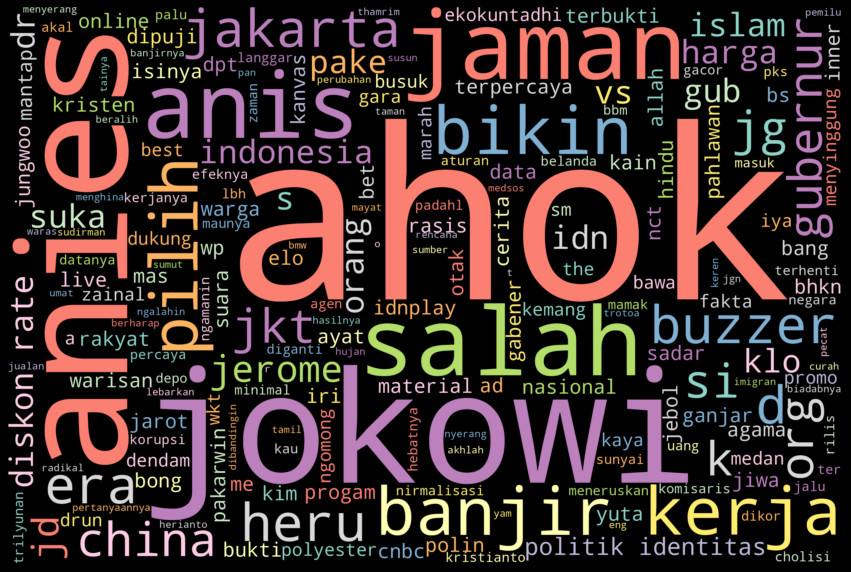

In [18]:
from wordcloud import WordCloud
from PIL import Image

data_tweet = []

for data in df['tweets']:
  data_tweet.append(tweet_cleaner(data))

text = str(data_tweet).replace("'","")

wordcloud = WordCloud(width=3000, height=2000,
                      max_words=200, colormap='Set3',
                      background_color="black",
                      stopwords=stop_words).generate(text)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Sentiment Analysis

In [19]:
df['sentiment'] = ''

In [20]:
pretrained_name = "w11wo/indonesian-roberta-base-indolem-sentiment-classifier-fold-0"

nlp = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name
)

Downloading:   0%|          | 0.00/796 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/808k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [21]:
tweet = df['tweets']
data = []

for i in tweet:
  data.append(nlp(i))

In [22]:
predicted_label = []
confidence = []

for my_list in data:
  for item in my_list:
    predicted_label.append(item['label'])
    confidence.append(item['score'])

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['sentiment'] = le.fit_transform(predicted_label)

In [24]:
df

,username,tweets,likes,followers,sentiment
0,Evan_sofian1980,"@Uki23 Emang gubernur jokowi kerjanya apa mas,...",0,11,0
1,Fr4nst,@Aswad4242 @d54714 @Uki23 Betul. Anies dpt war...,0,2508,1
2,Rick12101624,@detikcom Ini dari jaman belanda belum jadi ne...,1,27,0
3,DaengKayo89,@CupsCupu @Uki23 Jelas jelas itu ada datanya k...,0,569,1
4,democrazymedia,"Harga BBM Gak Masuk Akal, PKS Pertanyakan Kerj...",0,67979,0
...,...,...,...,...,...
95,dharmahutauruk,@marlina_idha Siapa yang jadi teladan mu? Ahok...,0,157,1
96,id3nesia,@JohnVirgoVj Jadi sebenarnya di Pilkada Jkt 20...,0,751,0
97,Mohammed_Dodi1,"Pak Heru gak salah,mas.\nPak Jokowi gak salah....",0,3383,1
98,Aldi38461127,@triwul82 Kelihatan banget settingannya... Cb ...,3,2,1


In [25]:
def get_analysis(score):
  if score == 0:
    return 'Negative'
  else:
    return 'Positive'

In [27]:
df['label'] = df['sentiment'].apply(get_analysis)

In [28]:
df

,username,tweets,likes,followers,sentiment,label
0,Evan_sofian1980,"@Uki23 Emang gubernur jokowi kerjanya apa mas,...",0,11,0,Negative
1,Fr4nst,@Aswad4242 @d54714 @Uki23 Betul. Anies dpt war...,0,2508,1,Positive
2,Rick12101624,@detikcom Ini dari jaman belanda belum jadi ne...,1,27,0,Negative
3,DaengKayo89,@CupsCupu @Uki23 Jelas jelas itu ada datanya k...,0,569,1,Positive
4,democrazymedia,"Harga BBM Gak Masuk Akal, PKS Pertanyakan Kerj...",0,67979,0,Negative
...,...,...,...,...,...,...
95,dharmahutauruk,@marlina_idha Siapa yang jadi teladan mu? Ahok...,0,157,1,Positive
96,id3nesia,@JohnVirgoVj Jadi sebenarnya di Pilkada Jkt 20...,0,751,0,Negative
97,Mohammed_Dodi1,"Pak Heru gak salah,mas.\nPak Jokowi gak salah....",0,3383,1,Positive
98,Aldi38461127,@triwul82 Kelihatan banget settingannya... Cb ...,3,2,1,Positive


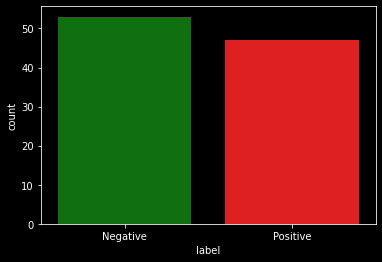

In [30]:
import seaborn as sns
sns.countplot(x=df["label"], data=df, palette=['Green',"Red"] )

### Gensim Model

In [52]:
import os
import nltk
nltk.download('punkt')

from tqdm.auto import tqdm
from nltk import word_tokenize
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
temp = []
for i in df["tweets"]:
    temp.append(i)

In [48]:
result = []
for j in temp:
    result.append(tweet_cleaner(j))

In [50]:
df_gensim = pd.DataFrame({"cleaned_tweet": result})
df_gensim

,cleaned_tweet
0,emang gubernur jokowi kerjanya apa mas nirmali...
1,betul anies dpt warisan untuk meneruskan proga...
2,ini dari jaman belanda belum jadi negara sudah...
3,jelas jelas itu ada datanya kok cnbc juga rili...
4,harga bbm gak masuk akal pks pertanyakan kerja...
...,...
95,idha siapa yang jadi teladan mu ahok vs anies
96,jadi sebenarnya di pilkada jkt itu anies masih...
97,pak heru gak salah mas pak jokowi gak salah pa...
98,kelihatan banget settingannya cb tanya enakan ...


In [53]:
sentences = [word_tokenize(comment) for comment in tqdm(df_gensim["cleaned_tweet"])]

  0%|          | 0/100 [00:00<?, ?it/s]

In [54]:
sentences[:5]

[['emang',
  'gubernur',
  'jokowi',
  'kerjanya',
  'apa',
  'mas',
  'nirmalisasi',
  'sunyai',
  'doang',
  'tapi',
  'gak',
  'ada',
  'efeknya',
  'ketika',
  'diganti',
  'ahok'],
 ['betul',
  'anies',
  'dpt',
  'warisan',
  'untuk',
  'meneruskan',
  'progam',
  'ahok',
  'atau',
  'paling',
  'tdk',
  'membuat',
  'progam',
  'lbh'],
 ['ini',
  'dari',
  'jaman',
  'belanda',
  'belum',
  'jadi',
  'negara',
  'sudah',
  'banjir',
  'tapi',
  'sempat',
  'terhenti',
  'di',
  'jaman',
  'jokowi',
  'dan',
  'ahok',
  'ter'],
 ['jelas',
  'jelas',
  'itu',
  'ada',
  'datanya',
  'kok',
  'cnbc',
  'juga',
  'rilis',
  'masa',
  'saya',
  'lebih',
  'percaya',
  'kamu',
  'daripada',
  'cnbc'],
 ['harga',
  'bbm',
  'gak',
  'masuk',
  'akal',
  'pks',
  'pertanyakan',
  'kerja',
  'ahok',
  'sebagai',
  'komisaris']]

In [55]:
model = Word2Vec(sentences=sentences,
                 size=512,
                 window=20, 
                 min_count=2, 
                 workers=10,
                 iter=1000)

In [59]:
model.similar_by_word("jakarta", topn=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('ad', 0.8118914365768433),
 ('pilih', 0.6790589094161987),
 ('justru', 0.6731978058815002),
 ('warga', 0.6492053866386414),
 ('ayat', 0.6179704070091248),
 ('jangan', 0.5931665897369385),
 ('orang', 0.5359960794448853),
 ('mau', 0.5283413529396057),
 ('bukti', 0.5224218964576721),
 ('gara', 0.5126813650131226)]

In [60]:
words = list(model.wv.vocab)
print(words)

['emang', 'gubernur', 'jokowi', 'apa', 'mas', 'doang', 'tapi', 'gak', 'ada', 'ketika', 'ahok', 'betul', 'anies', 'dpt', 'warisan', 'progam', 'atau', 'ini', 'dari', 'jaman', 'belum', 'jadi', 'sudah', 'banjir', 'di', 'dan', 'jelas', 'itu', 'kok', 'cnbc', 'juga', 'saya', 'lebih', 'kamu', 'harga', 'kerja', 's', 'bet', 'slot', 'online', 'idn', 'live', 'casino', 'terpercaya', 'indonesia', 'k', 'idnplay', 'dr', 'lah', 'yg', 'rakyat', 'jebol', 'tanya', 'jg', 'sama', 'pak', 'mau', 'bikin', 'hindu', 'pilih', 'padahal', 'bisa', 'kristen', 'banyak', 'yang', 'bang', 'selama', 'data', 'jkt', 'bhkn', 'klo', 'org', 'pasti', 'tahu', 'tai', 'pada', 'anis', 'agar', 'suara', 'ke', 'ganjar', 'aja', 'siapa', 'hanya', 'lalu', 'ayat', 'buat', 'biasa', 'si', 'ya', 'pakarwin', 'tanpa', 'pahlawan', 'nasional', 'salah', 'vs', 'waktu', 'kita', 'china', 'boleh', 'bagi', 'dia', 'warga', 'jakarta', 'jangan', 'rasis', 'ternyata', 'terus', 'kalau', 'bs', 'nya', 'ad', 'bukti', 'justru', 'lo', 'era', 'gub', 'jarot', 'isi

In [61]:
X = model[model.wv.vocab]

df_embedding = pd.DataFrame(X)
df_embedding.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.033634,0.002668,0.135368,0.253793,-0.113885,0.239108,0.424832,0.254328,0.087867,-0.258921,...,-0.115889,-0.261283,-0.397861,-0.233595,-0.060938,-0.289162,-0.272063,0.271619,-0.089152,0.197504
1,0.122485,0.302146,-0.094187,-0.183448,-0.099365,-0.113196,-0.193179,0.402566,0.302500,-0.000219,...,0.048719,0.289087,-0.510838,-0.127162,-0.090966,-0.584630,-0.251638,-0.132745,0.082903,0.384216
2,0.049994,0.019307,-0.359531,-0.015334,-0.067794,-0.097099,-0.132804,0.042192,0.066406,0.063895,...,0.035583,-0.399464,-0.060813,0.332673,0.129452,-0.202568,0.027993,0.376029,0.033292,-0.041504
3,-0.012663,-0.304864,0.099932,0.215115,-0.178667,0.074313,-0.082445,0.434083,0.114217,-0.034541,...,-0.412903,-0.256970,0.073608,0.602148,0.213735,-0.127596,-0.153790,0.263629,0.143834,-0.072634
4,0.064935,0.188692,-0.013407,0.524773,0.054010,0.422639,-0.110350,0.506599,-0.031456,-0.380061,...,0.113712,-0.353086,-0.124093,-0.049015,0.295194,-0.824802,-0.371508,0.264746,0.230154,1.265374


In [63]:
import numpy as np

X_corr = df_embedding.corr()
values, vectors = np.linalg.eig(X_corr)
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]
new_vectors=vectors[:, :2]
new_X = np.dot(X, new_vectors)

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1769: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(x))
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1771: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:828: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:829: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:690: ComplexWarning: Casting complex values t

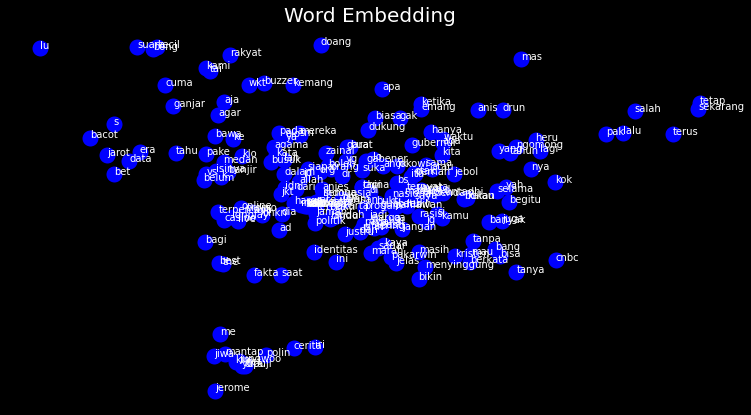

In [64]:
plt.figure(figsize=(13,7))
plt.scatter(new_X[:, 0], new_X[:, 1], linewidths=10, color='blue')
plt.title("Word Embedding", size=20)
plt.axis('off')
vocab=list(model.wv.vocab)
for i, word in enumerate(vocab):
  plt.annotate(word,xy=(new_X[i, 0], new_X[i, 1]))

### 3D Word Embedding

In [65]:
from keras.layers import Embedding

In [67]:
all_texts = df_gensim['cleaned_tweet'].to_numpy()
all_texts

array(['emang gubernur jokowi kerjanya apa mas nirmalisasi sunyai doang tapi gak ada efeknya ketika diganti ahok',
       'betul anies dpt warisan untuk meneruskan progam ahok atau paling tdk membuat progam lbh',
       'ini dari jaman belanda belum jadi negara sudah banjir tapi sempat terhenti di jaman jokowi dan ahok ter',
       'jelas jelas itu ada datanya kok cnbc juga rilis masa saya lebih percaya kamu daripada cnbc',
       'harga bbm gak masuk akal pks pertanyakan kerja ahok sebagai komisaris',
       's bet agen slot online gacor idn live casino terpercaya di indonesia minimal depo k s bet idnplay',
       'padahl anies dpt warisan dr ahok',
       'kristianto itu lah hebatnya jokowi ahok yg langgar aturan yg korupsi di',
       'palu ngamanin uang rakyat mamak kau zaman jokowi ahok jebol trilyunan dikor',
       'cholisi tanya jg sama pak jokowi dan pak ahok kok mau maunya bikin jalu',
       'pertanyaannya benarkah hindu tamil pilih ahok dan menghina anies di medsos jgn samp

In [69]:
all_cleaned_texts = np.array([tweet_cleaner(text) for text in all_texts])
all_cleaned_texts

array(['emang gubernur jokowi kerjanya apa mas nirmalisasi sunyai doang tapi gak ada efeknya ketika diganti ahok',
       'betul anies dpt warisan untuk meneruskan progam ahok atau paling tdk membuat progam lbh',
       'ini dari jaman belanda belum jadi negara sudah banjir tapi sempat terhenti di jaman jokowi dan ahok ter',
       'jelas jelas itu ada datanya kok cnbc juga rilis masa saya lebih percaya kamu daripada cnbc',
       'harga bbm gak masuk akal pks pertanyakan kerja ahok sebagai komisaris',
       's bet agen slot online gacor idn live casino terpercaya di indonesia minimal depo k s bet idnplay',
       'padahl anies dpt warisan dr ahok',
       'kristianto itu lah hebatnya jokowi ahok yg langgar aturan yg korupsi di',
       'palu ngamanin uang rakyat mamak kau zaman jokowi ahok jebol trilyunan dikor',
       'cholisi tanya jg sama pak jokowi dan pak ahok kok mau maunya bikin jalu',
       'pertanyaannya benarkah hindu tamil pilih ahok dan menghina anies di medsos jgn samp

In [70]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cleaned_texts)

In [71]:
all_encoded_texts = tokenizer.texts_to_sequences(all_cleaned_texts)
all_encoded_texts = np.array(all_encoded_texts)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [72]:
for i in range(5):
  print('Length of file', i, ':', len(all_encoded_texts[i]))

Length of file 0 : 16
Length of file 1 : 14
Length of file 2 : 18
Length of file 3 : 16
Length of file 4 : 11


In [74]:
from keras.utils import pad_sequences

all_encoded_texts = pad_sequences(all_encoded_texts, maxlen=50)
all_encoded_texts

array([[  0,   0,   0, ...,  96, 206,   1],
       [  0,   0,   0, ..., 211,  99, 212],
       [  0,   0,   0, ...,   9,   1, 217],
       ...,
       [  0,   0,   0, ..., 704,  11,  41],
       [  0,   0,   0, ..., 711,  32, 712],
       [  0,   0,   0, ..., 724,  92, 725]], dtype=int32)

In [75]:
from keras.models import Sequential

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=500))

In [76]:
# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

(726, 64)


In [77]:
reverse_word_index = tokenizer.index_word

In [78]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, 500):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [79]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Shareable embedding projector link: 
- https://projector.tensorflow.org/?config=https://raw.githubusercontent.com/algonacci/Free-CDN/main/template_projector_config.json

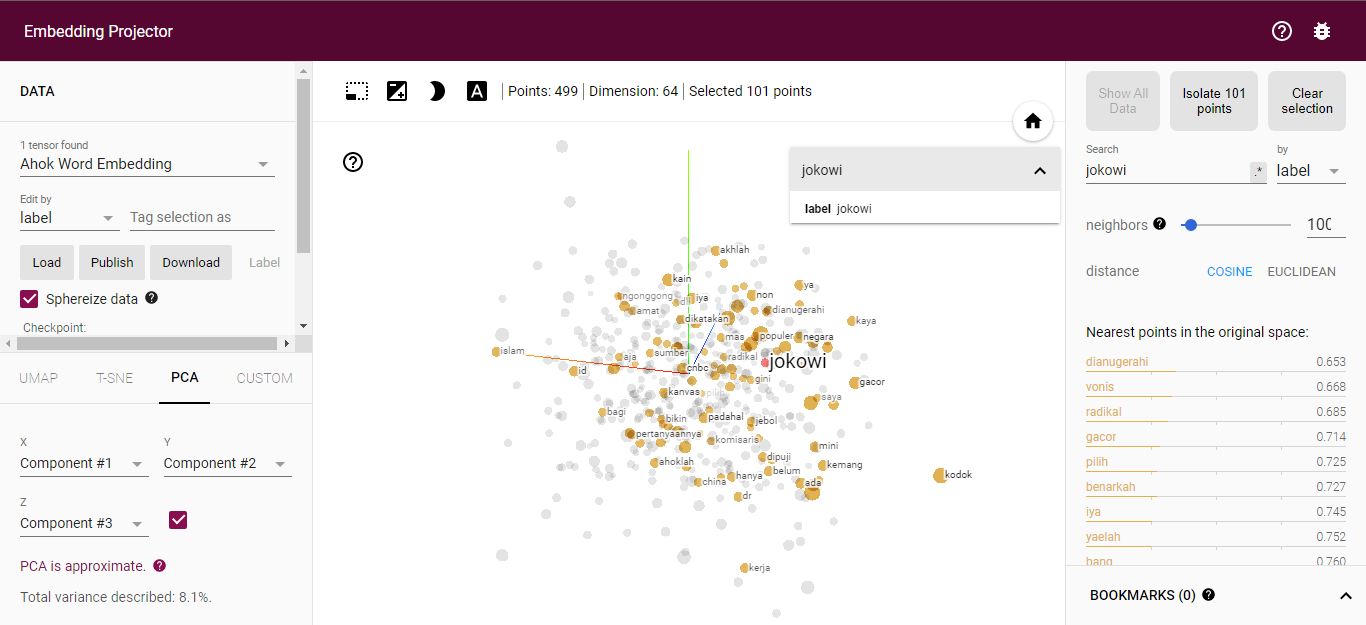